In [24]:
import numpy as np
from scipy.integrate import solve_ivp

import sympy as sp
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

init_vprinting()

<img src="sho_sketch.png" alt="simple harmonic oscillator" width="400"/>

The simple harmonic oscillator is a system that features a mass $m$ attached to a spring with spring constant $k$, which determines the stiffness of the spring. The mass is free to move in one dimension, and the spring is attached to a wall. The position of the mass is given by $x(t)$, and the force on the mass is given by Hooke's law:
$$F = -kx$$
This says that the force on the mass is proportional to the displacement of the mass from its equilibrium position, and that the force is in the opposite direction of the displacement. The negative sign indicates that the force is a restoring force, which means that the force acts to return the mass to its equilibrium position. The equation of motion for the mass is given by Newton's second law:
$$F = ma = m \ddot x = -kx$$
where $a$ is the acceleration of the mass, and $\ddot x$ is the second derivative of the position with respect to time. This is a second-order differential equation, which means that it contains second derivatives of the position with respect to time. While this is an easy differential equation to get to with Newton's second law, we can also use Lagrangian mechanics to get to the same equation of motion. The Lagrangian for this system is given by:
$$\mathcal{L} = T - V$$
where $T$ is the kinetic energy of the system, and $V$ is the potential energy of the system. The kinetic energy is given by:
$$T = \frac{1}{2} m v^2$$
where $v$ is the velocity of the mass, and $m$ is the mass of the mass. The velocity is the first derivative of the position with respect to time, so we can write the kinetic energy as:
$$T = \frac{1}{2} m \dot x^2$$
where $\dot x$ is the first derivative of the position with respect to time. In this case, the potential energy $V$ is elastic potential energy and not gravitational potential energy. So we cannot use the equation $V = mgh$ to calculate the potential energy. Instead, we use the equation for elastic potential energy:
$$V = \frac{1}{2} k x^2$$
where $k$ is the spring constant, and $x$ is the displacement of the mass from its equilibrium position. The Lagrangian for the system is then:
$$\mathcal{L} = \frac{1}{2} m \dot x^2 - \frac{1}{2} k x^2$$

In [25]:
# Create symbolic variables
m, k, t = sp.symbols('m k t')
omega_0 = sp.symbols('omega_0', positive=True) # (sqrt(k/m)) - natural angular frequency
x = dynamicsymbols('x')

# Initial conditions
x_0 = sp.symbols('x_0') # initial position
v_0 = sp.symbols('v_0') # initial velocity


# Derivative of x
x_dot = sp.diff(x, t)
x_ddot = sp.diff(x_dot, t)

# Lagrangian
T = sp.Rational(1, 2) * m * x_dot**2

V = sp.Rational(1, 2) * k * x**2

L = T - V

In [26]:
print("Lagrangian:")
L.simplify()

Lagrangian:


### Euler-Lagrange Equation

$$
\dfrac{d}{dt} \bigg( \dfrac{\partial \mathcal{L}}{\partial \dot q_i} \bigg) - \dfrac{\partial \mathcal{L}}{\partial q_i} = 0
$$

$$
\big \Downarrow
$$

$$
\dfrac{d}{dt} \bigg( \dfrac{\partial \mathcal{L}}{\partial \dot x} \bigg) - \dfrac{\partial \mathcal{L}}{\partial x} = 0
$$

In [27]:
# Euler-Lagrange Equation
eq = sp.diff(sp.diff(L, x_dot), t) - sp.diff(L, x)

# Solve for x_ddot
solution = sp.Eq(x_ddot, sp.solve(eq, x_ddot)[0])

solution = solution.replace(-k*x/m, -omega_0**2*x)

solution

We have one ODE, meaning ordinary differential equations. An ODE is an equation that contains a function of one independent variable and its derivatives. In this case, the independent variable is time, $t$. Since this ODE is simple enough, we can use `sp.dsolve` to get an exact solution for it, giving us the position function $x(t)$.

In [28]:
pos = sp.dsolve(solution, x).rhs # position function

pos

Now we have a function of $x$ which describes the position of the mass as a function of time. Note that there are two constants, $C_1$ and $C_2$, that are the constants of integration from solving the differential equation. We must find what these constants represent.

In [29]:
print("Initial position:")
pos.subs(t, 0)

Initial position:


By setting $t = 0$, we can find the inital position of the mass. This gives us the constant $C_2$. Now we should differentiatiate our position function to get the velocity function.

In [30]:
vel = sp.diff(pos, t) # velocity function

print("Velocity:")
vel

Velocity:


In [31]:
print("Initial velocity:")
vel.subs(t, 0)

Initial velocity:


We get the constant $C_1$ times $\omega_0$ from setting $t = 0$ in the velocity function. This means that  $C_1 
\omega_0$ is the initial velocity of the mass. We can now solve for $C_1$.

$$
C_1 = \dfrac{v_0}{\omega_0}
$$

Our position function $x(t) = C_1 \cos(|\omega| t) + C_2 \sin(\omega t)$ can now be written as:

$$
x(t) = \dfrac{v_0}{\omega_0} \cos(\omega_0 t) + x_0 \sin(\omega t)
$$
$$
\omega_0 = \sqrt{\dfrac{k}{m}}
$$

where $x_0$ is the initial position and $v_0$ is the initial velocity.

In [32]:
pos = pos.replace(sp.symbols('C2'), x_0).replace(sp.symbols('C1'), v_0/omega_0)

pos

In [33]:
vel = vel.replace(sp.symbols('C2'), x_0).replace(sp.symbols('C1'), v_0/omega_0)

vel

Now, we have the functions for the position and velocity of the mass in respect to time. We also know all of the constants in the equations. We are now able to plot the position and velocity given some initial conditions. First, we need to get an array of positions and velocities for a given time interval. We can use the `linspace` function from the `numpy` library to get an array of times. We would then convert the symbolic expressions into numeric functions with the `lambdify` function from the `sympy` library. We can then use the `lambdify` functions to get arrays of positions and velocities for the given time interval.

In [34]:
# Initial conditions
param_ell = 6 # m (position of equilibrium - distance of equilibrium from wall)

param_x_0 = 5 # m (initial position)
param_v_0 = 1 # ms^-1 (initial velocity)

param_m = 3 # kg (mass)
param_k = 2 # Nm^-1 (spring constant)

param_omega_0 = np.sqrt(param_k/param_m) # rad s^-1 (natural angular frequency)

parameters = (param_x_0, param_v_0, param_omega_0)

if np.abs(param_x_0) > param_ell:
    raise ValueError("Initial distance of mass from equilibrium must be less than or equal to the distance of equilibrium from the wall.")

# Time array
t_0 = 0
t_f = 10
time = np.linspace(t_0, t_f, (t_f - t_0) * 25) # @ 25 fps

# Symbolic to numeric functions
pos_f = sp.lambdify((t, x_0, v_0, omega_0), pos, 'numpy')
vel_f = sp.lambdify((t, x_0, v_0, omega_0), vel, 'numpy')

# Position and velocity arrays
pos_array = pos_f(time, *parameters)
vel_array = vel_f(time, *parameters)

np.savetxt(
    'simple_harmonic_oscillator.csv',
    np.transpose([time, pos_array, vel_array]),
    delimiter=',',
    header='time, position, velocity'
)

Now we can use the `plt.plot` function from `matplotlib` to plot our data. We will plot the postion and velocity against time. We can also change some of the default parameters of the plotting function to give us a dark mode colour scheme.

In [35]:
plt.rcParams["axes.facecolor"] = "black"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["axes.titlecolor"] = "white"
plt.rcParams["figure.facecolor"] = "black"
plt.rcParams["legend.labelcolor"] = "white"
plt.rcParams["xtick.labelcolor"] = "white"
plt.rcParams["ytick.labelcolor"] = "white"
plt.rcParams["grid.color"] = "#707070"

In [70]:
def alignYaxes(axes, align_values=None):
    '''Align the ticks of multiple y axes

    Args:
        axes (list): list of axes objects whose yaxis ticks are to be aligned.
    Keyword Args:
        align_values (None or list/tuple): if not None, should be a list/tuple
            of floats with same length as <axes>. Values in <align_values>
            define where the corresponding axes should be aligned up. E.g.
            [0, 100, -22.5] means the 0 in axes[0], 100 in axes[1] and -22.5
            in axes[2] would be aligned up. If None, align (approximately)
            the lowest ticks in all axes.
    Returns:
        new_ticks (list): a list of new ticks for each axis in <axes>.

        A new sets of ticks are computed for each axis in <axes> but with equal
        length.
    '''
    from matplotlib.pyplot import MaxNLocator

    nax=len(axes)
    ticks=[aii.get_yticks() for aii in axes]
    if align_values is None:
        aligns=[ticks[ii][0] for ii in range(nax)]
    else:
        if len(align_values) != nax:
            raise Exception("Length of <axes> doesn't equal that of <align_values>.")
        aligns=align_values

    bounds=[aii.get_ylim() for aii in axes]

    # align at some points
    ticks_align=[ticks[ii]-aligns[ii] for ii in range(nax)]

    # scale the range to 1-100
    ranges=[tii[-1]-tii[0] for tii in ticks]
    lgs=[-np.log10(rii)+2. for rii in ranges]
    igs=[np.floor(ii) for ii in lgs]
    log_ticks=[ticks_align[ii]*(10.**igs[ii]) for ii in range(nax)]

    # put all axes ticks into a single array, then compute new ticks for all
    comb_ticks=np.concatenate(log_ticks)
    comb_ticks.sort()
    locator=MaxNLocator(nbins='auto', steps=[1, 2, 2.5, 3, 4, 5, 8, 10])
    new_ticks=locator.tick_values(comb_ticks[0], comb_ticks[-1])
    new_ticks=[new_ticks/10.**igs[ii] for ii in range(nax)]
    new_ticks=[new_ticks[ii]+aligns[ii] for ii in range(nax)]

    # find the lower bound
    idx_l=0
    for i in range(len(new_ticks[0])):
        if any([new_ticks[jj][i] > bounds[jj][0] for jj in range(nax)]):
            idx_l=i-1
            break

    # find the upper bound
    idx_r=0
    for i in range(len(new_ticks[0])):
        if all([new_ticks[jj][i] > bounds[jj][1] for jj in range(nax)]):
            idx_r=i
            break

    # trim tick lists by bounds
    new_ticks=[tii[idx_l:idx_r+1] for tii in new_ticks]

    # set ticks for each axis
    for axii, tii in zip(axes, new_ticks):
        axii.set_yticks(tii)

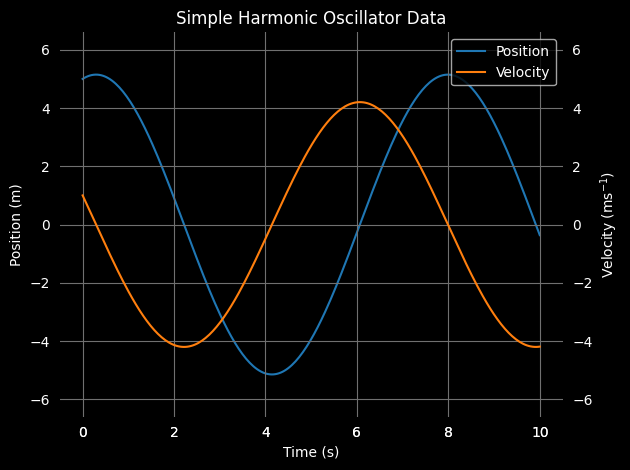

In [89]:
fig = plt.figure()


ax1 = fig.add_subplot(111, label="1")
ax2 = fig.add_subplot(111, label="2", frame_on=False)

pos_line = ax1.plot(time, pos_array, color="tab:blue")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Position (m)")


vel_line = ax2.plot(time, vel_array, color="tab:orange")
ax2.yaxis.tick_right()
ax2.set_ylabel("Velocity (ms$^{-1}$)")
ax2.yaxis.set_label_position("right")

alignYaxes([ax1, ax2], [0, 0])

# make axis extend a bit more
ax1.set_ylim(1.1 * ax1.get_ylim()[0], 1.1 * ax1.get_ylim()[1])
ax2.set_ylim(1.1 * ax2.get_ylim()[0], 1.1 * ax2.get_ylim()[1])


plt.legend(pos_line + vel_line, ["Position", "Velocity"], loc="upper right")

plt.title("Simple Harmonic Oscillator Data")
plt.grid()
plt.tight_layout()


plt.savefig("Figures/simple_harmonic_oscillator_data.png", dpi=300)
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_7940\3556099722.py:36: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point1.set_data(time[i], pos_array[i])
C:\Users\Owner\AppData\Local\Temp\ipykernel_7940\3556099722.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point2.set_data(time[i], vel_array[i])


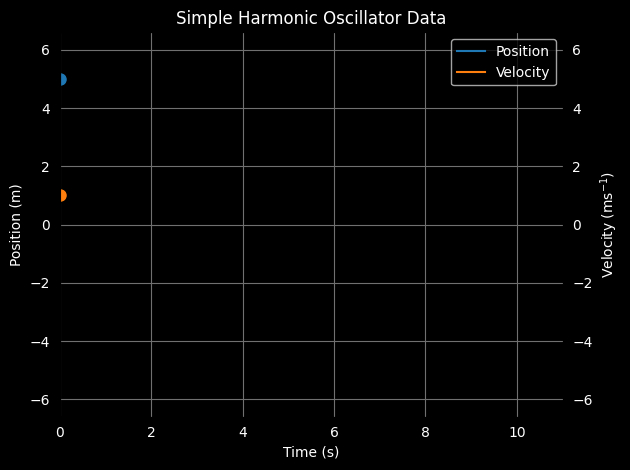

In [92]:
fig, ax = plt.subplots()
plt.title("Simple Harmonic Oscillator Data")

ax1 = plt.gca() # get current axis
ax2 = ax1.twinx() # create twin axis

line1, = ax1.plot([], [], color="tab:blue")
line2, = ax2.plot([], [], color="tab:orange")

point1, = ax1.plot([], [], color="tab:blue", marker="o", markersize=8)
point2, = ax2.plot([], [], color="tab:orange", marker="o", markersize=8)

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Position (m)")
ax2.set_ylabel("Velocity (ms$^{-1}$)")

ax1.set_xlim(t_0, t_f)
ax1.set_ylim(1.1 * np.min(pos_array), 1.1 * np.max(pos_array))
ax2.set_ylim(1.1 * np.min(vel_array), 1.1 * np.max(vel_array))

alignYaxes([ax1, ax2], [0, 0])

# make axis extend a bit more
ax1.set_xlim(1.1 * ax1.get_xlim()[0], 1.1 * ax1.get_xlim()[1])
ax1.set_ylim(1.1 * ax1.get_ylim()[0], 1.1 * ax1.get_ylim()[1])
ax2.set_ylim(1.1 * ax2.get_ylim()[0], 1.1 * ax2.get_ylim()[1])


plt.legend(pos_line + vel_line, ["Position", "Velocity"], loc="upper right")
ax1.grid()

plt.tight_layout()

def animate(i):
    line1.set_data(time[:i], pos_array[:i])
    point1.set_data(time[i], pos_array[i])
    line2.set_data(time[:i], vel_array[:i])
    point2.set_data(time[i], vel_array[i])


ani = animation.FuncAnimation(fig, animate, frames=len(time), interval=50)
ani.save("Animations/simple_harmonic_oscillator_data.gif", writer="pillow", fps=25)


Let's plot the energy of the system as a function time. We will plot the kinetic and potential energies, as well as the total energy of the system. As we have used an exact solution of our differential equation for the position and velocity, there should be no inaccuracies in the data. This would mean that the total energy of the system should be constant. Energy will have units of Joules (J), which we can see with the kinetic energy formula. $T = \frac{1}{2} m v^2 \rightarrow kg \cdot m^2 \cdot s^{-2} = J$. We will first have to get arrays of the energies.

In [38]:
# Kinetic Energy
kinetic_f = sp.lambdify((m, x_dot), T, 'numpy')

kinetic_array = kinetic_f(param_m, vel_array)

# Potential Energy
potential_f = sp.lambdify((k, x), V, 'numpy')

potential_array = potential_f(param_k, pos_array)

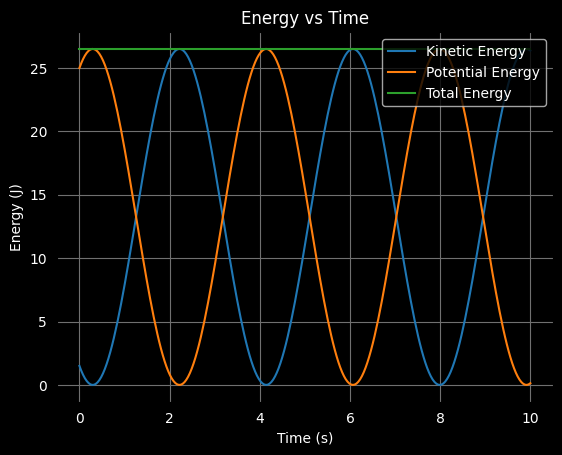

In [44]:
plt.plot(time, kinetic_array)
plt.plot(time, potential_array)

plt.plot(time, kinetic_array + potential_array)

plt.title("Energy vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.legend(["Kinetic Energy", "Potential Energy", "Total Energy"], loc="upper right")
plt.grid()

plt.savefig("Figures/simple_harmonic_oscillator_energy.png", dpi=300)
plt.show()

The momentum of the system can also be plotted. Momentum is given by $p = mv$, where $p$ is momentum, $m$ is mass, and $v$ is velocity. Momentum will have units of $kg \cdot m \cdot s^{-1}$, which we can see from the formula. $p = mv \rightarrow kg \cdot m \cdot s^{-1} = kg \cdot m \cdot s^{-1}$. We will first have to get an array of the momentum. We already have an array of the velocity, so we can just multiply the mass by the velocity array to get the momentum array.

In [42]:
momentum = m * x_dot

momentum_f = sp.lambdify((m, x_dot), momentum, 'numpy')

momentum_array = momentum_f(param_m, vel_array)

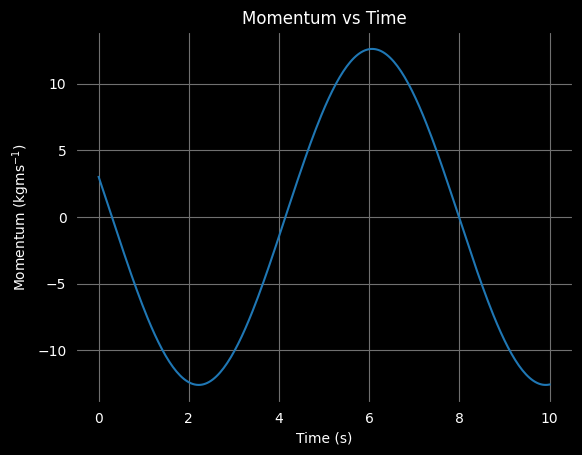

In [43]:
plt.plot(time, momentum_array)

plt.title("Momentum vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Momentum (kgms$^{-1}$)")

plt.grid()

plt.savefig("Figures/simple_harmonic_oscillator_momentum.png", dpi=300)
plt.show()

We can also plot the phase space of the system, which is a graph showing every possible state. We can do this by using the position and velocity arrays that we have already calculated and plotting them against each other with `plt.plot` from `matplotlib`.

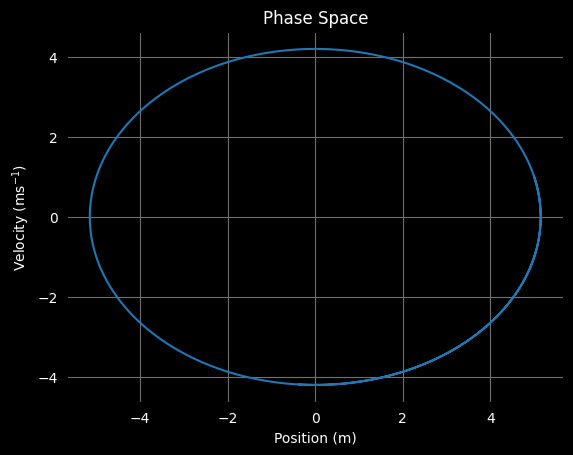

In [17]:
plt.plot(pos_array, vel_array)

plt.title("Phase Space")
plt.xlabel("Position (m)")
plt.ylabel("Velocity (ms$^{-1}$)")
plt.grid()

plt.savefig("Figures/simple_harmonic_oscillator_phase_space.png", dpi=300)
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_7940\1780084908.py:17: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  phase_point.set_data(pos_array[i], vel_array[i])


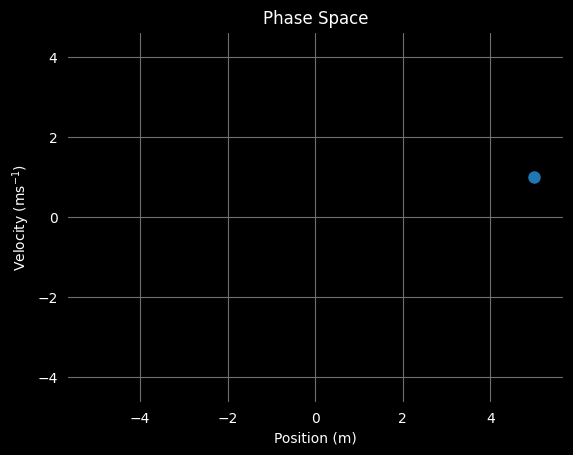

In [18]:
fig, ax = plt.subplots()
plt.title("Phase Space")

phase_curve, = ax.plot([], [], color="tab:blue")
phase_point, = ax.plot([], [], color="tab:blue", marker="o", markersize=8)

ax.set_xlabel("Position (m)")
ax.set_ylabel("Velocity (ms$^{-1}$)")

ax.set_xlim(1.1 * np.min(pos_array), 1.1 * np.max(pos_array))
ax.set_ylim(1.1 * np.min(vel_array), 1.1 * np.max(vel_array))

ax.grid()

def animate(i):
    phase_curve.set_data(pos_array[:i], vel_array[:i])
    phase_point.set_data(pos_array[i], vel_array[i])
    
ani = animation.FuncAnimation(fig, animate, frames=len(time), interval=50)
ani.save("Animations/simple_harmonic_oscillator_phase_space.gif", writer="pillow", fps=25)

We can animate the motion of the mass by using the `animation` module from `matplotlib`. We will use the `FuncAnimation` function to animate it. To do this, we will need to create a function that updates the position of the mass at each time step. We already have all of the positions in a given time frame in an array, so we can just use the index of the array to get the position at each time step in our time array.

One thing to note is that so far, we have described our system in a way that the equilibrium position is at $x = 0$. This means that the mass is at rest when $x = 0$. However, for animation, it may make sense to have $x = 0$ as the wall that the spring is attached to. We can define the distance from the wall to the equilibrium position as $\ell$. We can just add this to the position function to get the position of the mass relative to the wall.

$$
x(t) = \ell + \dfrac{v_0}{\omega_0} \cos(\omega_0 t) + x_0 \sin(\omega t)
$$


In [19]:
new_pos_array = pos_array + param_ell

I got this [Spring Function](https://github.com/nrsyed/utilities/tree/master/spring) from the internet. It is a function that takes in a start and end coordinates, as well as the number of nodes and width of a spring. Those are then use to return an array of x values and an array of y values that can be used to plot the string. I have used this function to animate my spring. I had to make the width greater than the length divided by the number of nodes. Otherwise, the formula for the spring would not work and it would default to returning a straight line.

The start and end points of the spring are a bit more and less than point $x=0$ and the point where the mass is. This was so I could fit a two straight lines, for aesthetic purposes. The spring and those lines have lengths that are dependant on the current position of the mass. This makes it so as the position decreases, the spring gets compressed and vice versa for when the position increases. Note that this is all in reference to the x-axis. The y-axis is not affected by the position of the mass so I have just set it to 0 for everything.

In [20]:
def spring(start, end, nodes, width):
    """!
    Return a list of points corresponding to a spring.

    @param r1 (array-like) The (x, y) coordinates of the first endpoint.
    @param r2 (array-like) The (x, y) coordinates of the second endpoint.
    @param nodes (int) The number of spring "nodes" or coils.
    @param width (int or float) The diameter of the spring.
    @return An array of x coordinates and an array of y coordinates.
    """

    # Check that nodes is at least 1.
    nodes = max(int(nodes), 1)

    # Convert to numpy array to account for inputs of different types/shapes.
    start, end = np.array(start).reshape((2,)), np.array(end).reshape((2,))

    # If both points are coincident, return the x and y coords of one of them.
    if (start == end).all():
        return start[0], start[1]

    # Calculate length of spring (distance between endpoints).
    length = np.linalg.norm(np.subtract(end, start))

    # Calculate unit vectors tangent (u_t) and normal (u_t) to spring.
    u_t = np.subtract(end, start) / length
    u_n = np.array([[0, -1], [1, 0]]).dot(u_t)

    # Initialize array of x (row 0) and y (row 1) coords of the nodes+2 points.
    spring_coords = np.zeros((2, nodes + 2))
    spring_coords[:,0], spring_coords[:,-1] = start, end

    # Check that length is not greater than the total length the spring
    # can extend (otherwise, math domain error will result), and compute the
    # normal distance from the centerline of the spring.
    normal_dist = np.sqrt(max(0, width**2 - (length**2 / nodes**2))) / 2

    # Compute the coordinates of each point (each node).
    for i in range(1, nodes + 1):
        spring_coords[:,i] = (
            start
            + ((length * (2 * i - 1) * u_t) / (2 * nodes))
            + (normal_dist * (-1)**i * u_n))

    return spring_coords[0,:], spring_coords[1,:]

C:\Users\Owner\AppData\Local\Temp\ipykernel_7940\694546876.py:25: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(new_pos_array[i], 0)


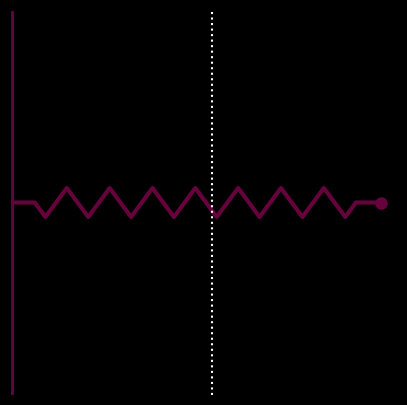

In [21]:
def animate(i):
    # Create the spring line, width has to be greater than length/nodes
    nodes_num = 15
    length = new_pos_array[i] - new_pos_array[i]/nodes_num
    
    spring_line = spring(start = (new_pos_array[i]/nodes_num, 0),
                         end = (length, 0),
                         nodes = nodes_num,
                         width = length/nodes_num + 0.05 * param_ell
                         )


    # Create lines to fill the starting and ending gaps, both of length (1/nodes_num)*new_pos_array[i]
    start_line = (np.array([0, new_pos_array[i]/nodes_num]), np.array([0, 0]))
    end_line = (np.array([length, new_pos_array[i]]), np.array([0,0]))
    
    # Append the start and end lines to the spring line
    spring_line = (np.append(start_line[0], spring_line[0]), np.append(start_line[1], spring_line[1]))
    spring_line = (np.append(spring_line[0], end_line[0]), np.append(spring_line[1], end_line[1]))

    # Set the data for the line
    ln1.set_data(spring_line[0], spring_line[1])
    
    # plot the position of the mass
    point.set_data(new_pos_array[i], 0)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.set_facecolor("k") # enable this to hide background
ax.get_xaxis().set_ticks([]) # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([]) # enable this to hide y axis ticks


# Plot the spring

ln1, = plt.plot([], [], lw=3, markersize=8, color="#66023c", linestyle="-")
point, = plt.plot([], [], lw=0, markersize=8, color="#66023c", marker="o")


wall = plt.axvline(x=0, color="#66023c", linestyle="-", lw=5)

equilibrium_point = plt.axvline(x=param_ell, color="w", linestyle=":")


ax.set_xlim(0, param_ell + np.abs(param_x_0) * 1.1)
ax.set_ylim(-np.abs(param_x_0), np.abs(param_x_0))

ani = animation.FuncAnimation(fig, animate, frames=len(time), interval=50)
ani.save("Animations/simple_harmonic_oscillator.gif", writer="pillow", fps=25)

On further topics on the simple harmonic oscillator in this notebook, we can once again treat the equilibrium positon as being $x=0$ for the sake of simpler calculations and formulae, such as the position function.

We can get some important values of our system from what we have solved. Firstly, let's get the frequency of the oscillations. We can do this by using the equation $\omega_0 = \sqrt{\frac{k}{m}}$. This is our angular frequency, so our frequency is gotten from this: $f = \frac{\omega_0}{2\pi}$.

The frequency of the oscillations is the number of oscillations per second. What our value tells us is that the frequency is not dependant on time, rather being decided by the mass, $m$, and the spring constant, $k$, which are both constant values of the system. A frequency graph versus time would thus be a horizontal line.

We can also find the period of the oscillations. The period is the time it takes for one oscillation. We can get this by taking the inverse of the frequency. $T = \frac{1}{f}$. This gives us the equation for $T$, which is: $T = \frac{2\pi}{\omega_0}$.

These two values shows us that our system for simple harmonic motion is isochronous, meaning that the period and frequency not dependant on the amplitude of the oscillations. This is because the period and frequency are only dependant on the mass and spring constant; the amplitude is dependant on different constants of the system. 

We can get the amplitude from this:

$$
A = \sqrt{C_1^2 + C_2^2}
$$
$$
A = \sqrt{\left(\dfrac{v_0}{|\omega|}\right)^2 + x_0^2}
$$

Here, $C_1$ and $C_2$ are the constants from solving our differential equation to get the position function. We used differentiation and made $t=0$ show that $C_1 = \frac{v_0}{\omega_0}$ and $C_2 = x_0$. The amplitude is dependant on two initial conditions of the system, the initial position and velocity, instead of the mass and spring constant. With the amplitude, we can write our position function as:

$$
x(t) = A \cos(\omega_0 t - \phi_0)
$$

where $\phi_0$ is the initial phase, at $t=0$. The initial phase is:

$$
\phi_0 = \arctan\left(\dfrac{C_1}{C_2}\right)
$$

The phase is dependant on the initial position and velocity, as well as the mass and spring constant. The phase is the fraction of the period that has passed since the start of the period. This means that it is period, the fraction resets every period when the position function is at its amplitude. We can write a phase function of time as:

$$
\phi(t) = 2\pi \left(\left(\frac{t - t_0}{T}\right) - \left\lfloor\frac{t - t_0}{T}\right\rfloor\right)
$$

Here, $T$ is the period of the oscillations and $t_0$ is an arbitrary origin value for our function. $\phi(t)$ is a periodic function, such that $\phi(t + T) = \phi(t)$ for any $t$. For the simple harmonic oscillator, our value of $t_0$ is $0$. This means that our phase function is:

$$
\phi(t) = 2\pi \left(\frac{t}{T} - \left\lfloor\frac{t}{T}\right\rfloor\right)
$$

In [48]:
frequecy = param_omega_0/(2*np.pi)

period = 1/frequecy

amplitude = np.sqrt(param_x_0**2 + (param_v_0/np.abs(param_omega_0))**2)

print(f"Frequency = {frequecy:.2f} Hz, Period = {period:.2f} s, Amplitude = {amplitude:.2f} m")

Frequency = 0.13 Hz, Period = 7.70 s, Amplitude = 5.15 m


phi_0 = 0.16 rad


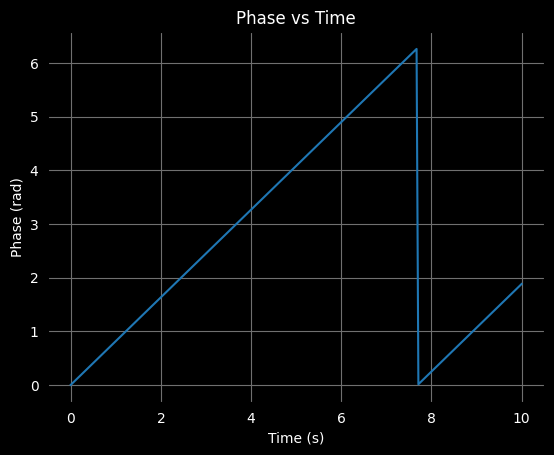

In [49]:
phi_0 = np.arctan((param_v_0*param_omega_0)/param_x_0)

phi = 2*np.pi*((time/period - np.floor(time/period)))

plt.plot(time, phi)
plt.xlabel("Time (s)")
plt.ylabel("Phase (rad)")
plt.title("Phase vs Time")
plt.grid()

plt.savefig("Figures/simple_harmonic_oscillator_phase_vs_time.png", dpi=300)

print(f"phi_0 = {phi_0:.2f} rad")
plt.show()